## Classic ML models

In [53]:
import pandas as pd
import os
import numpy as np
import scipy

import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tqdm

In [10]:
fname = "../Datasets/ChargePoint Data CY20Q4 SPATAIL.csv"
df = pd.read_csv(fname, index_col=0)
spatial_fname = "../Datasets/spatial_populartimes.csv"
spatial_features = pd.read_csv(spatial_fname, index_col=0)


/Users/mikhailgasanov/geo/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 1. Select categories 

In [249]:
target_categories = ['shopping_mall', 'restaurant', 'cafe',
       'grocery_or_supermarket', 'bar',
       'beauty_salon']
spatial_features = spatial_features.loc[spatial_features['category'].isin(target_categories)]

## 2. Prepare spatial features

In [308]:
def get_spatial_features(row: pd.Series):
    target_categories = ['shopping_mall', 'restaurant', 'cafe',
       'grocery_or_supermarket', 'bar',
       'beauty_salon']
    dictPopular = dict.fromkeys(target_categories, 0)
    cluster = row['cluster']
    select = spatial_features.loc[spatial_features['cluster']==cluster]
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    dow = weekDays[row['Start Date'].dayofweek]
    hour = row['Start Date'].hour + 1
    res = select.groupby('category').mean().loc[: ,dow+'_'+str(hour)]
    for cat in res.keys(): 
        dictPopular[cat] = res[cat]        
    
    return dictPopular

In [313]:
sp_list = []
for row in tqdm.notebook.tqdm(df.iterrows()):
    sp_list.append(get_spatial_features(row[1]))

0it [00:00, ?it/s]

In [317]:
res_df = pd.concat([df, pd.DataFrame(sp_list)], axis=1)

## 3. Prepare weather features

In [319]:
weather = pd.read_csv('../Datasets/weather_palalto.csv', index_col=0)

In [320]:
cols = ['DAY', 'TEMP', 'RAIN']
weather = weather[cols]
weather.loc[:, 'Start Date'] = pd.to_datetime(weather['DAY'])

In [321]:
weather['DAY'] = pd.to_datetime(weather['DAY'])

In [323]:
res_df.loc[:, 'DAY'] = res_df['Start Date'].dt.floor('D')

In [324]:
df_weather = res_df.merge(weather, on = 'DAY')

In [327]:
df_weather = df_weather.drop(columns=['Start Date_y', 'DAY', 'Start'])

In [328]:
df_weather.to_csv('../Datasets/PalAlto_Spatial_Weather.csv')

## End 🙏

In [11]:
cols = ['Station Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)',
       'Latitude', 'Longitude', 'latitude', 'longitude', 'cluster']
df = df[cols]

In [16]:
df.loc[:, 'Start Date'] = pd.to_datetime(df.loc[:, 'Start Date'], format='%m/%d/%Y %H:%M')
df['Start'] = pd.to_datetime(df['Start Date'], format='%m/%d/%Y %H:%M')
df['Start'] = df['Start'].dt.floor('D')

df = df.set_index('Start Date')

In [44]:
def getGrouped(df:pd.DataFrame)->pd.DataFrame:
    """
    Group dataframe daily and hourly
    """
    return df.groupby((df.index.dayofweek) * 24 + (df.index.hour)).sum()

In [153]:
CLUSTER = 4

In [154]:
cluster_mask = df['cluster'] == CLUSTER
cluster_df =  getGrouped(df.loc[cluster_mask])

cluster_df = df.loc[cluster_mask]
cluster_df = getGrouped(cluster_df)
cluster_df = cluster_df.reindex(range(169)).fillna(0.)

Text(0, 0.5, 'Energy (kWh)')

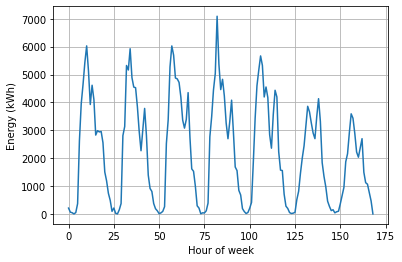

In [155]:
cluster_df['Energy (kWh)'].plot()
plt.grid()
plt.xlabel('Hour of week')
plt.ylabel('Energy (kWh)')

In [156]:
mask_spatial = spatial_features['cluster']==CLUSTER
spatial_df = spatial_features.loc[mask_spatial]

grouped_T = spatial_df.groupby('category').mean().T.iloc[:-6,:]

In [195]:
grouped_T

category,index,bar,cafe,clothing_store,electronics_store,locality,night_club,point_of_interest,restaurant,shopping_mall,spa,Energy (kWh)
0,Monday_1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,34.907469
1,Monday_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,70.984215
2,Monday_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
3,Monday_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
4,Monday_5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
163,Sunday_20,41.5,37.0,0.0,0.0,19.0,36.0,0.0,65.75,0.0,64.0,1245.937247
164,Sunday_21,38.5,0.0,0.0,0.0,15.0,11.0,0.0,58.75,0.0,61.0,1327.334936
165,Sunday_22,0.0,0.0,0.0,0.0,11.0,12.0,0.0,41.00,0.0,57.0,1126.898770
166,Sunday_23,0.0,0.0,0.0,0.0,8.0,11.5,0.0,0.00,0.0,46.0,826.045134


In [196]:
sns.set_context('talk')

In [202]:
grouped_T.columns

Index(['index', 'bar', 'cafe', 'clothing_store', 'electronics_store',
       'locality', 'night_club', 'point_of_interest', 'restaurant',
       'shopping_mall', 'spa', 'Energy (kWh)'],
      dtype='object', name='category')

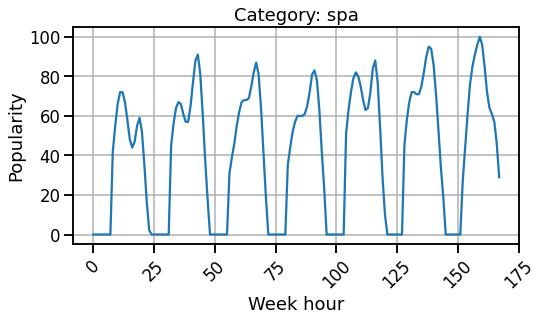

In [205]:
cat = 'spa'
plt.figure(figsize=(8,4))
grouped_T[cat].plot()
plt.xticks(rotation=45)
plt.grid()
plt.title(f"Category: {cat}")
plt.xlabel('Week hour')
plt.ylabel('Popularity')
plt.show()

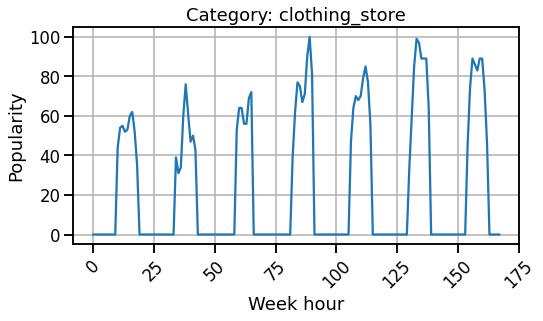

In [204]:
cat = 'clothing_store'
plt.figure(figsize=(8,4))
grouped_T[cat].plot()
plt.xticks(rotation=45)
plt.grid()
plt.title(f"Category: {cat}")
plt.xlabel('Week hour')
plt.ylabel('Popularity')
plt.show()


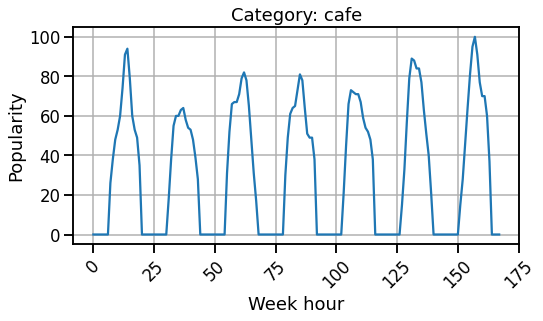

In [201]:
cat = 'cafe'
plt.figure(figsize=(8,4))
grouped_T['cafe'].plot()
plt.xticks(rotation=45)
plt.grid()
plt.title(f"Category: {cat}")
plt.xlabel('Week hour')
plt.ylabel('Popularity')
plt.show()


In [159]:
grouped_T = grouped_T.reset_index()
grouped_T.loc[:, 'Energy (kWh)'] = cluster_df['Energy (kWh)']

In [161]:
def getDayNight(x:str)->bool:
    weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
    nightHours = [str(i) for i in [21,22,23,24,1,2,3,4,5,6,7,8]]
    for day in weekDays:
        for hour in nightHours:
            if x == day+'_'+hour:
                return 'Night'
            
    return 'Day'
        

In [162]:
grouped_T.loc[:, 'night_day'] = grouped_T['index'].apply(lambda x: getDayNight(x))

In [163]:
grouped_T = grouped_T.loc[grouped_T['night_day']=='Day']

ValueError: Could not interpret value `grocery_or_supermarket` for parameter `y`

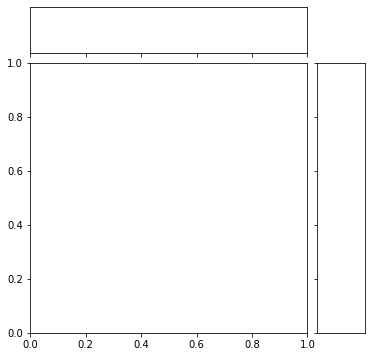

In [164]:
cat = 'grocery_or_supermarket'
g = sns.jointplot(x='Energy (kWh)', y=cat, data=grouped_T,
                  color=sns.color_palette()[0])#color="#5d5d60")

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['Energy (kWh)'], data[cat])
    ax = plt.gca()
    ax.text(.01, .95, f'$R^2$ = {r:.2f}',
            transform=ax.transAxes, size=17)
r, p = scipy.stats.pearsonr(grouped_T['Energy (kWh)'], grouped_T[cat])
g.ax_joint.tick_params(axis='both', which='major', labelsize=12)
sns.regplot(x='Energy (kWh)', y=cat, data=grouped_T, ax=g.ax_joint, scatter=False, color=sns.color_palette()[0])
g.set_axis_labels(xlabel = 'Energy (kWh)', ylabel=f'Popular times - {cat}',fontsize=14)
g.ax_joint.grid('on')
plt.suptitle(f"Correlation $R^2$:{r:.2f}")
# plt.savefig(f'./scatter_soil.png', dpi=300, bbox_inches='tight')
plt.show()

In [167]:
# Fill diagonal and upper half with NaNs
corr = grouped_T.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/ipykernel_4957/978642386.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


category,bar,cafe,clothing_store,electronics_store,locality,night_club,point_of_interest,restaurant,shopping_mall,spa,Energy (kWh)
category,,,,,,,,,,,
bar,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cafe,-0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
clothing_store,-0.24,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan
electronics_store,0.26,0.29,0.71,nan,nan,nan,nan,nan,nan,nan,nan
locality,0.32,-0.39,-0.02,0.11,nan,nan,nan,nan,nan,nan,nan
night_club,0.72,-0.32,0.18,0.55,0.28,nan,nan,nan,nan,nan,nan
point_of_interest,-0.26,0.20,-0.04,-0.12,0.02,-0.40,nan,nan,nan,nan,nan
restaurant,0.74,-0.26,0.18,0.57,0.01,0.84,-0.32,nan,nan,nan,nan
shopping_mall,-0.16,0.58,0.88,0.84,-0.08,0.22,-0.05,0.29,nan,nan,nan


In [165]:
normalized_df=(grouped_T-grouped_T.mean())/grouped_T.std()

/var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/ipykernel_4957/2031611844.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(grouped_T-grouped_T.mean())/grouped_T.std()


In [166]:
normalized_df[cat].plot(label=f'Catergory: {cat}')
normalized_df["Energy (kWh)"].plot(label='Energy (kWh)')
plt.grid()
plt.legend()

KeyError: 'grocery_or_supermarket'

In [229]:

cluster_mask = df['cluster'] ==17
cluster_df =  getGrouped(df.loc[cluster_mask])
cluster_df = df.loc[cluster_mask]
cluster_df = getGrouped(cluster_df)
cluster_df = cluster_df.reindex(range(169)).fillna(0.)
mask_spatial = spatial_features['cluster']==CLUSTER
spatial_df = spatial_features.loc[mask_spatial]
grouped_T = spatial_df.groupby('category').mean().T.iloc[:-6,:]
grouped_T = grouped_T.reset_index()
grouped_T.loc[:, 'Energy (kWh)'] = cluster_df['Energy (kWh)']
# Fill diagonal and upper half with NaNs
corr = grouped_T.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.iloc[-1:,:]
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))


/var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/ipykernel_4957/2251395664.py:16: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



category,bar,cafe,clothing_store,electronics_store,locality,night_club,point_of_interest,restaurant,shopping_mall,spa,Energy (kWh)
category,,,,,,,,,,,
Energy (kWh),0.47,0.06,0.03,0.15,0.32,0.45,-0.08,0.56,0.03,0.39,nan


In [182]:
import geopandas as gpd

In [183]:
grp = df.groupby(['latitude', 'longitude'], as_index=False).mean()

gdf = gpd.GeoDataFrame(data=grp, geometry=gpd.points_from_xy(x=grp['latitude'],y=grp['longitude' ]))

In [187]:
gdf['cluster'] = gdf['cluster'].astype(int)
gdf['cluster'] = gdf['cluster'].astype(str)

In [194]:

gdf.loc[gdf['cluster'] == '14']

,latitude,longitude,Energy (kWh),Latitude,Longitude,cluster,geometry
12,37.445,-122.139,9.402301,37.445497,-122.138897,14,POINT (37.445 -122.139)


In [191]:
import plotly.express as px
import base64
import plotly.graph_objects as go

token = open('../.mapbox_token').read()


fig_1 = px.scatter_mapbox(gdf, lat='Latitude', lon='Longitude',
                          color='cluster',
#                          color_continuous_scale='blues',
                          zoom=13, height=600)

fig_1.update_layout(mapbox_style="satellite",mapbox_accesstoken=token )

fig_1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig_1.update_traces(marker=dict(size=16))